## Part I: Preparing Data

In [1]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

### Loading data

In [2]:
DATA_PATH = "/content/drive/MyDrive/coronavirus-source-data/owid-covid-data.csv"

data_pd = pd.read_csv(DATA_PATH)

Выберем из таблицы данные по России, начиная с `3 марта 2020 г.` (в этот момент впервые стало больше 2 заболевших).

In [3]:
data_pd["date"] =  pd.to_datetime(data_pd["date"]).dt.normalize()

In [4]:
data_pd["date"]

0        2020-02-24
1        2020-02-25
2        2020-02-26
3        2020-02-27
4        2020-02-28
            ...    
166549   2022-03-02
166550   2022-03-03
166551   2022-03-04
166552   2022-03-05
166553   2022-03-06
Name: date, Length: 166554, dtype: datetime64[ns]

In [5]:
rus_march_mask = (
    (data_pd["date"] >= "2020-03-03") & 
    (data_pd["location"] == "Russia")
)
data_pd = data_pd[rus_march_mask].reset_index()

Даны данные за 734 дня

In [6]:
data_pd['date'].nunique()

734

In [7]:
data_pd.shape

(734, 68)

In [8]:
data_pd.sample(3)

,index,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
638,124593,RUS,Europe,Russia,2021-12-01,9500836.0,32196.0,32850.143,271091.0,1191.0,...,23.4,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN
178,124133,RUS,Europe,Russia,2020-08-28,977730.0,4758.0,4722.714,16866.0,108.0,...,23.4,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN
652,124607,RUS,Europe,Russia,2021-12-15,9927150.0,28011.0,29215.857,287135.0,1112.0,...,23.4,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN


In [9]:
data_pd.loc[(data_pd.new_cases == 0), "new_cases"] = 1

### Training & testing samples

Для единообразия давайте зафиксируем тренировочный набор в виде первых 50 отсчётов (дней), начиная с 3 марта. Остальные данные используем в качестве тестового набора (и он даже будет увеличиваться по мере выполнения задания).

In [10]:
train_date_begin = data_pd["date"].min().normalize()
train_date_end = train_date_begin + pd.DateOffset(days=49)
test_date_begin = train_date_end + pd.DateOffset(days=1)
test_date_end = data_pd["date"].max().normalize()

print("train_date_begin:", train_date_begin)
print("train_date_end", train_date_end)

print("test_date_begin:", test_date_begin)
print("test_date_end", test_date_end)

train_date_begin: 2020-03-03 00:00:00
train_date_end 2020-04-21 00:00:00
test_date_begin: 2020-04-22 00:00:00
test_date_end 2022-03-06 00:00:00


In [11]:
def train_test_split(feature_matrix, target, 
                     train_date_begin, train_date_end,
                     test_date_begin, test_date_end):
    "The date column must be set to index."
    train_X = feature_matrix.loc[train_date_begin:train_date_end]
    test_X = feature_matrix.loc[test_date_begin:test_date_end]
    train_y = target.loc[train_date_begin:train_date_end]
    test_y = target.loc[test_date_begin:test_date_end]
    return train_X, test_X, train_y, test_y

In [12]:
data_pd = data_pd.set_index("date")

In [13]:
train_X, test_X, train_y, test_y = train_test_split(
    data_pd.drop(["total_cases", "new_cases"], axis=1),
    data_pd.loc[:, ["total_cases", "new_cases"]],
    train_date_begin, train_date_end,  
    test_date_begin, test_date_end
)

In [14]:
print(
    f"""
    Размеры выборок, (объекты, признаки).
    - Обучающая: {train_X.shape}
    - Тестовая: {test_X.shape}
    """
)


    Размеры выборок, (объекты, признаки).
    - Обучающая: (50, 65)
    - Тестовая: (684, 65)
    


## Part II: 

## Построим графики целевых переменных

In [15]:
def plot_target_distributions(fig, ax, data, target_names, 
                              titles, colors, suptitle, 
                              xlabel, ylabel):
    # sns.set(style="whitegrid", font_scale=1.3)
    # sns.set_style({"font.family": "serif"})

    fig.subplots_adjust(bottom=0.2, top=0.85, wspace=0.1)
    fig.suptitle(suptitle, fontsize=25)
    fig.align_labels(axs=ax)

    for i, target_name in enumerate(target_names):
        ax[i].set_title(f"{target_name}", fontsize=22, pad=10)
        ax[i].set_xlabel(xlabel, fontsize=22, labelpad=10)
        ax[i].set_ylabel(ylabel, fontsize=22, labelpad=10)
        ax[i].ticklabel_format(style='sci', axis='y')
    ax[0].yaxis.set_label_position("left")
    ax[1].yaxis.set_label_position("right")
    ax[1].yaxis.tick_right()

    for i, target_name in enumerate(target_names):
        for sample_type in data.keys():
            ax[i].scatter(
                x=data[sample_type].index,
                y=data[sample_type].loc[:, target_name], 
                label=sample_type, 
                color=colors[sample_type], 
                alpha=0.75, edgecolor="gold", lw=0.2,
            )
        
        legend = ax[i].legend(framealpha=1)
        frame = legend.get_frame()
        frame.set_facecolor("white")
        frame.set_edgecolor("black")
        
        vals = ax[i].get_yticks()
        ax[i].set_yticklabels(["{:,}".format(x) for x in vals])
        ax[i].xaxis.set_tick_params(rotation=45)

    plt.show()

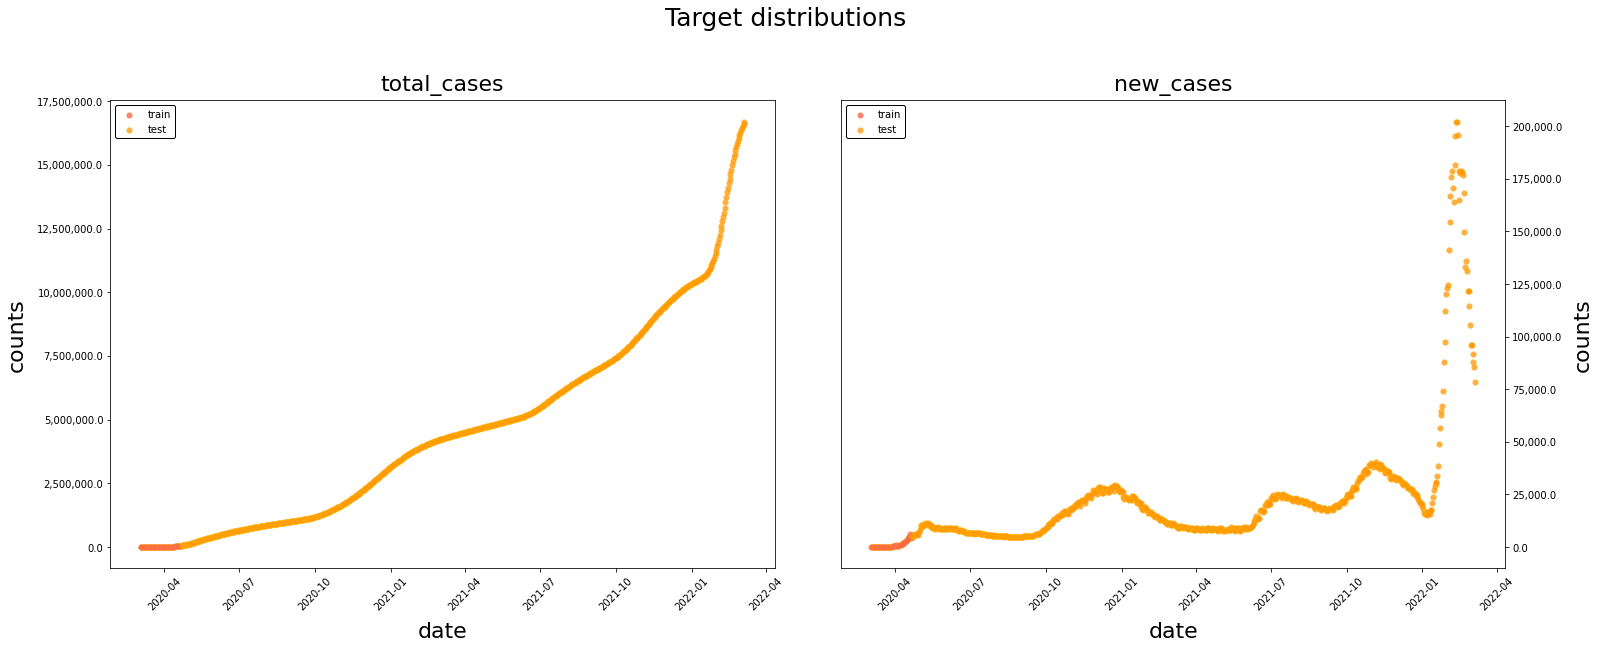

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(25, 10))
target_names = list(train_y.columns)

plot_target_distributions(fig, ax,
                          data={"train": train_y, 
                                "test": test_y},
                          target_names=target_names,
                          titles=["Total confirmed cases of COVID-19", 
                                  "New confirmed cases of COVID-19"],
                          colors={"train": "xkcd:coral",
                                  "test": "xkcd:tangerine"},
                          suptitle="Target distributions",
                          xlabel="date",
                          ylabel="counts")

Число заболевших растёт очень быстро, на первый взгляд экспоненциально. Для первого подхода к снаряду давайте это и используем.


### 2.1 Linear Regression

Используя линейную регрессию, обучим модель с экспоненциальным ростом числа заболевших: y ~ exp(линейная функция от x), где x — номер текущего дня.

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html


In [17]:
from sklearn.linear_model import LinearRegression

Пронумеруем наши дни (начиная с единицы)

In [18]:
test_X.shape[0]

684

In [19]:
train_day_nums = np.arange(0, train_X.shape[0]).reshape(-1, 1)
test_day_nums = np.arange(train_X.shape[0], train_X.shape[0] + test_X.shape[0]).reshape(-1, 1)

Логарифмируем целевые переменные

In [20]:
train_log_y = np.log(train_y)
test_log_y = np.log(test_y)

Обучим линейную регрессию

In [21]:
lin_reg_total = LinearRegression()
lin_reg_total.fit(train_day_nums,
                  np.array(train_log_y.total_cases.values).reshape(-1, 1))

lin_reg_new = LinearRegression()
lin_reg_new.fit(train_day_nums,
                np.array(train_log_y.new_cases.values).reshape(-1, 1))

LinearRegression()

In [22]:
pred_train_y_pd = pd.DataFrame()
pred_train_y_pd["total_cases"] = np.round(np.exp(lin_reg_total.predict(train_day_nums).flatten()))
pred_train_y_pd["new_cases"] = np.round(np.exp(lin_reg_new.predict(train_day_nums).flatten()))

pred_test_y_pd = pd.DataFrame()
pred_test_y_pd["total_cases"] = np.round(np.exp(lin_reg_total.predict(test_day_nums).flatten()))
pred_test_y_pd["new_cases"] = np.round(np.exp(lin_reg_new.predict(test_day_nums).flatten()))

In [23]:
pred_train_y_pd.index = train_y.index
pred_test_y_pd.index = test_y.index

In [24]:
test_y.merge(pred_test_y_pd, on="date")

,total_cases_x,new_cases_x,total_cases_y,new_cases_y
date,,,,
2020-04-22,57999.0,5236.0,1.249020e+05,1.504600e+04
2020-04-23,62773.0,4774.0,1.522950e+05,1.812100e+04
2020-04-24,68622.0,5849.0,1.856960e+05,2.182400e+04
2020-04-25,74588.0,5966.0,2.264220e+05,2.628400e+04
2020-04-26,80949.0,6361.0,2.760800e+05,3.165600e+04
...,...,...,...,...
2022-03-02,16353868.0,96180.0,3.713413e+63,1.035890e+59
2022-03-03,16445802.0,91934.0,4.527828e+63,1.247603e+59
2022-03-04,16533932.0,88130.0,5.520858e+63,1.502585e+59


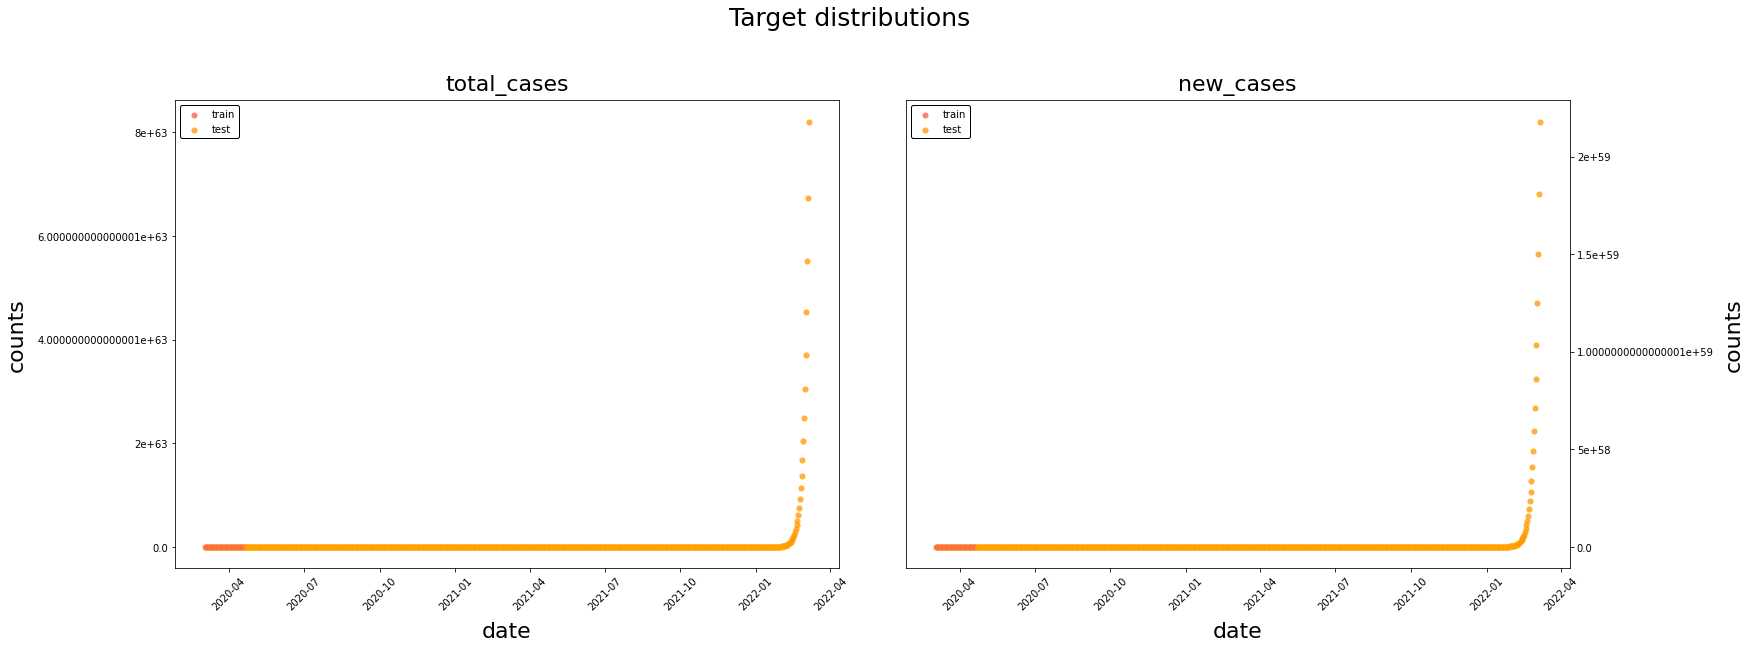

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(25, 10))
target_names = list(train_y.columns)

plot_target_distributions(fig, ax,
                          data={"train": pred_train_y_pd, 
                                "test": pred_test_y_pd},
                          target_names=target_names,
                          titles=["Total confirmed cases of COVID-19", 
                                  "New confirmed cases of COVID-19"],
                          colors={"train": "xkcd:coral",
                                  "test": "xkcd:tangerine"},
                          suptitle="Target distributions",
                          xlabel="date",
                          ylabel="counts")

### 2.2 Posterior parameters distributions

Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели (это фактически первый шаг эмпирического Байеса).

In [26]:
class GaussianDistribution:
    def __init__(self, mean, cov):
        self.mean = mean
        self.cov = cov

    def __str__(self):
        s = f"""Gaussian:
    mean={self.mean} 
    cov=\n{self.cov}
    """ 
        return s

В качестве априорного выберем нормальное с нулевым средним и диаогональной ковариационной матрицей

In [27]:
inv_alpha = 1e1
prior_distribution = GaussianDistribution(mean=np.zeros(2), 
                                          cov=np.eye(2)*inv_alpha)

In [28]:
print(prior_distribution)

Gaussian:
    mean=[0. 0.] 
    cov=
[[10.  0.]
 [ 0. 10.]]
    


Найдем апостериорное распределение (по формулам из лекции)

In [29]:
sigma_0_inv = np.linalg.inv(prior_distribution.cov)
mu_0 = prior_distribution.mean

variance = np.var(train_log_y.total_cases - np.log(pred_train_y_pd.total_cases))
print(f"Variance: {variance:.4}")

Fi = np.hstack((
    np.ones(50).reshape(-1, 1), 
    train_day_nums.reshape(-1, 1)
))

Variance: 0.1228


In [30]:
sigma_N = np.linalg.inv(sigma_0_inv + Fi.T @ Fi / variance)
mu_N = sigma_N @ (sigma_0_inv @ mu_0 + Fi.T @ train_y.total_cases / variance)

In [31]:
posterior_distribution = GaussianDistribution(mean=mu_N, 
                                              cov=sigma_N)

In [32]:
print(posterior_distribution)

Gaussian:
    mean=[-9627.07481786   727.83264593] 
    cov=
[[ 9.52837407e-03 -2.88738520e-04]
 [-2.88738520e-04  1.17881409e-05]]
    


### 2.3 Sampling of many different exponents

Посэмплируйте много разных экспонент, постройте графики. Сколько, исходя из этих сэмплов, предсказывается случаев коронавируса в России к 1 мая? к 1 июня? к 1 сентября? Постройте предсказательные распределения (можно эмпирически, исходя из данных сэмплирования).

In [33]:
def myplot_sample_lines(mu, sigma, n=100, points=None):
    # Посэмплируем и порисуем прямые
    my_w = np.random.multivariate_normal(mu, sigma, n)

    # plt.axis('equal')
    for w in my_w:
        plt.plot(train_day_nums, np.exp(w[0] + w[1]*train_day_nums), 'k-', lw=.4)

    if not points is None:
        plt.scatter(points[0], points[1], marker='*', s=200)

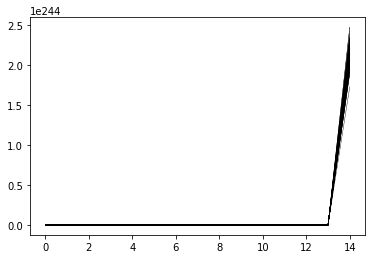

In [34]:
myplot_sample_lines(posterior_distribution.mean, 
posterior_distribution.cov)